In [24]:
from functools import partial
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from itertools import product
import time

from video699.screen.semantic_segmentation.fastai_detector import *
from video699.screen.semantic_segmentation.common import *
from video699.screen.semantic_segmentation.postprocessing import *
from video699.screen.semantic_segmentation.evaluation import *

In [25]:
detector = FastAIScreenDetector()

In [26]:
all_frames = [frame for video in ALL_VIDEOS for frame in video]
actual_detector = AnnotatedSampledVideoScreenDetector()

# Visualization

In [7]:
%%time
actuals = [actual_detector.detect(frame) for frame in tqdm(all_frames)]
preds = [detector.detect(frame) for frame in tqdm(all_frames)]
missed, ious, bad_ious = evaluate(actuals, preds)
np_ious = np.array(ious)
bad_ious = np.where(np_ious < 0.95)[0]

100%|██████████| 409/409 [00:27<00:00, 14.97it/s]


CPU times: user 25.1 s, sys: 2.24 s, total: 27.3 s
Wall time: 27.6 s


### Visualize performance

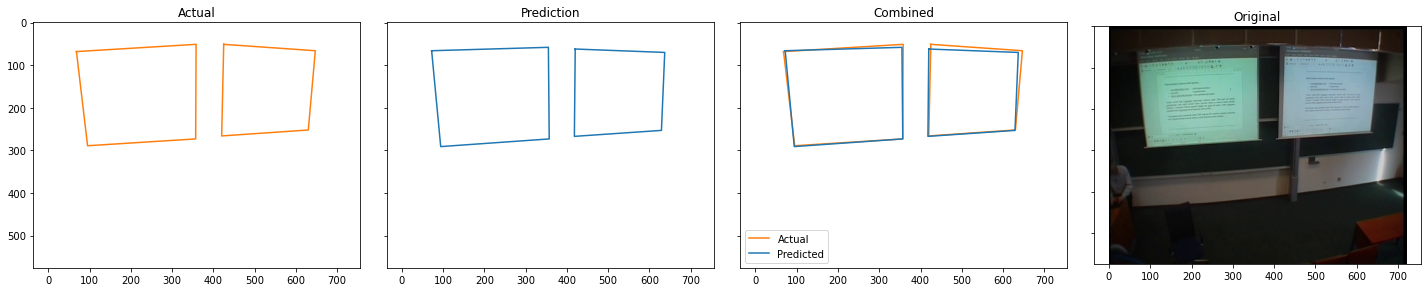

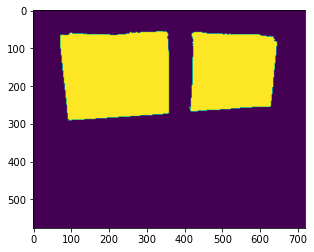

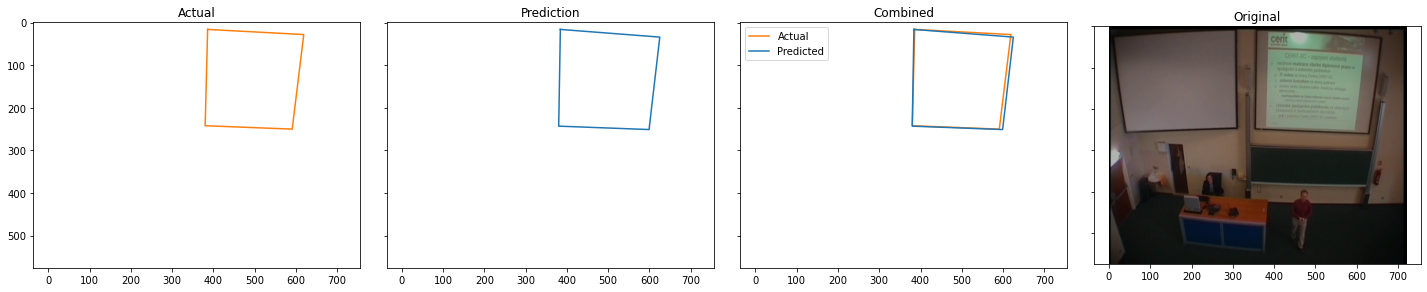

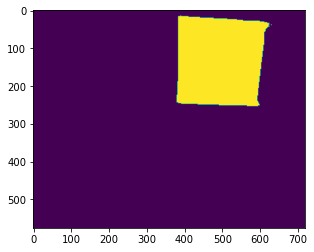

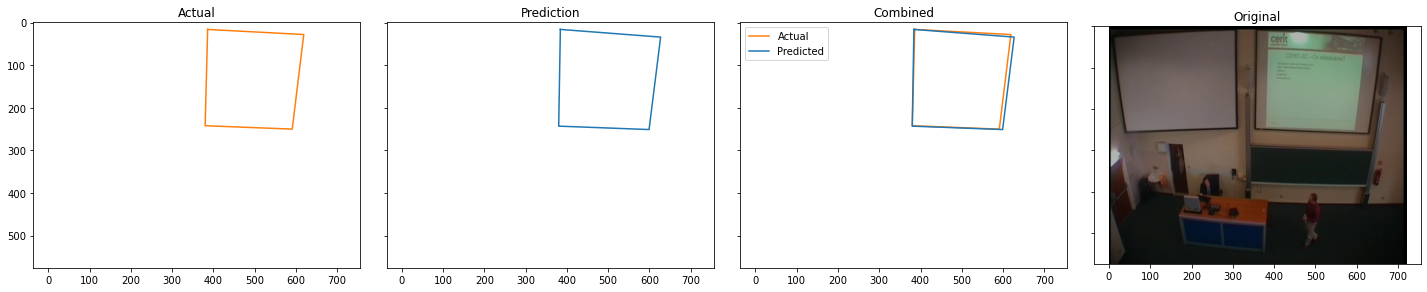

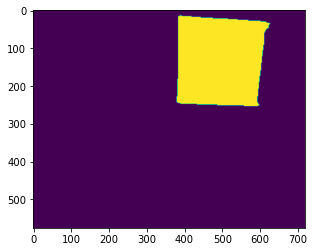

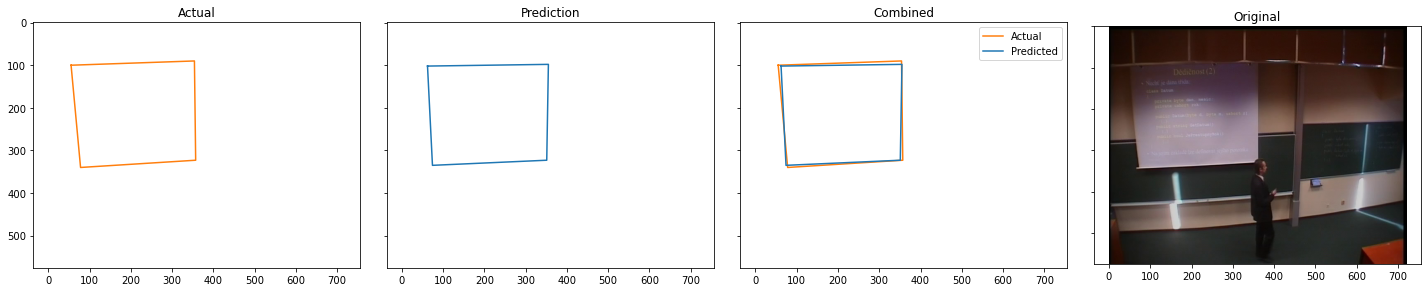

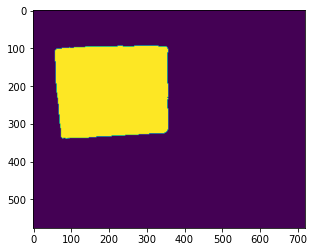

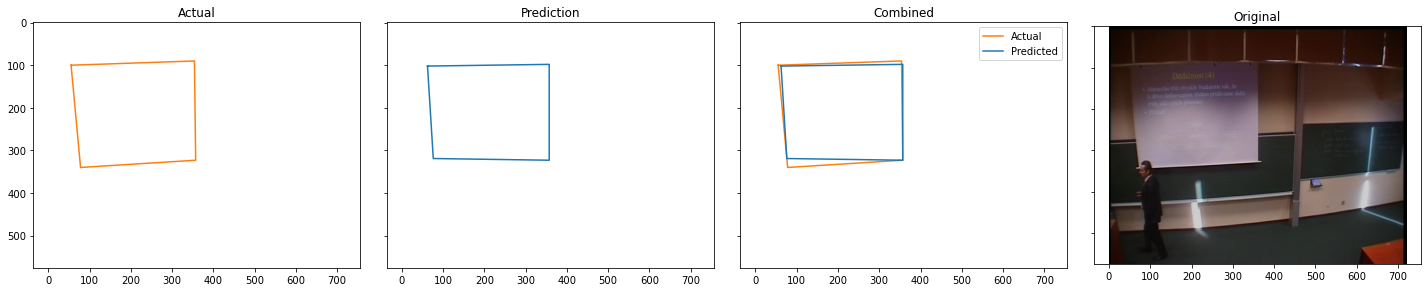

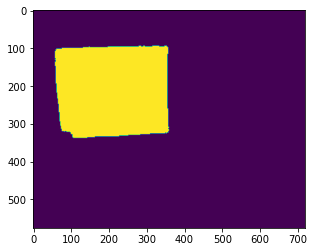

In [8]:
for index in bad_ious:
    frame = all_frames[index]
    actual_screens = actual_detector.detect(frame)
    pred_screens = detector.detect(frame)
    single_frame_visualization(frame, actual_screens, pred_screens)
    plt.imshow(detector.semantic_segmentation(frame))

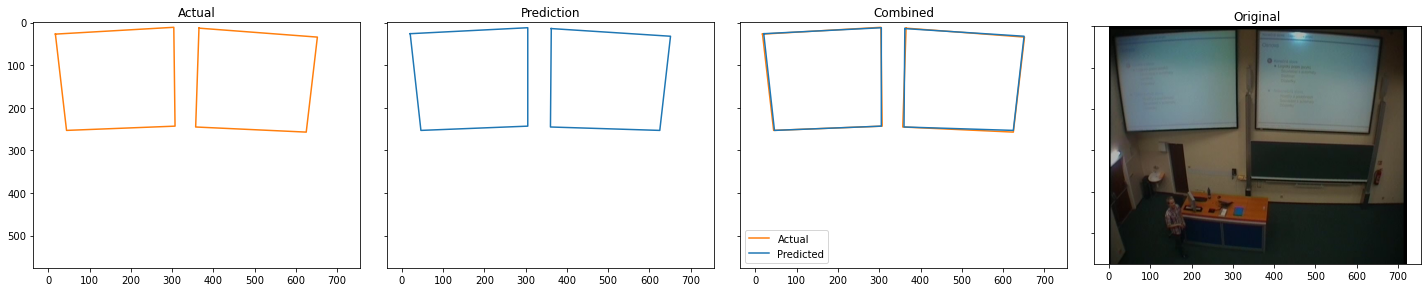

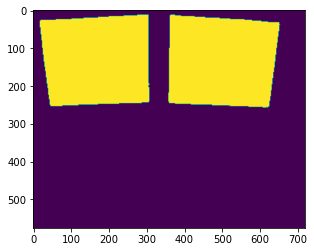

In [9]:
frame = all_frames[0]

actual_screens = actual_detector.detect(frame)
pred_screens = detector.detect(frame)
single_frame_visualization(frame, actual_screens, pred_screens)
plt.imshow(detector.semantic_segmentation(frame))

### Visualize transformations

In [10]:
from fastai.vision import open_image

tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=0,
                              max_zoom=1.0, max_lighting=0.8, max_warp=0,
                              p_affine=0, p_lighting=0)

def get_ex(): return open_image(all_frames[224].pathname)

def plots_f(rows, cols, width, height, **kwargs):
    fig, axis = plt.subplots(rows,cols,figsize=(width,height))
    fig.tight_layout()
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(axis.flatten())]
    fig.tight_layout()
    fig.savefig('transformation.png')

In [11]:
sample_img = [frame for frame in all_frames if 'frame002000.png' in frame.pathname and 'IA006-D1-20101110.avi' in frame.pathname][0]

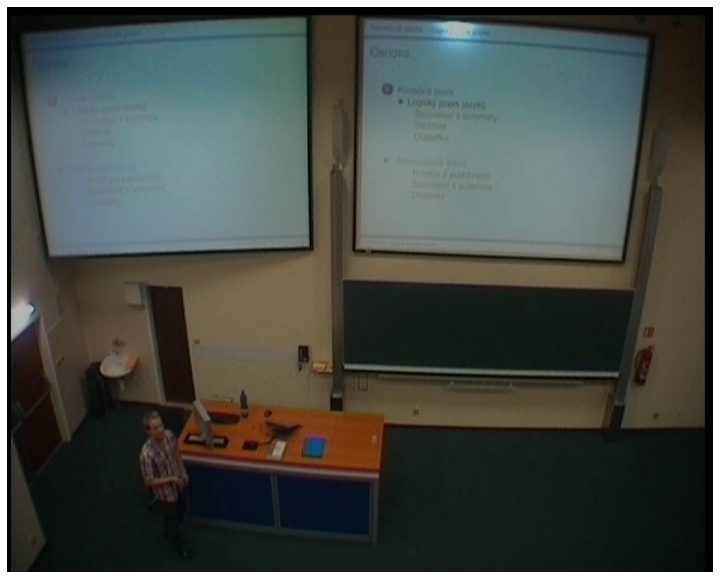

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10.10479417,8.4))
fig.tight_layout()
open_image(sample_img.pathname).apply_tfms(tfms[0], size=(576,720)).show(ax=ax)
fig.tight_layout()
fig.savefig('1_transformation.png', bbox_inches='tight', pad_inches=0)

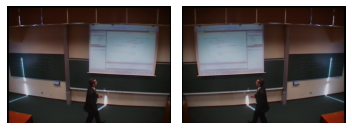

In [13]:
plots_f(1, 2, 5, 4, size=(512, 720))

## Visualize and evaluate methods

In [14]:
sems = [detector.semantic_segmentation(frame) for frame in tqdm(all_frames)]

100%|██████████| 409/409 [00:23<00:00, 17.70it/s]


In [15]:
def methods_visualization(frame, base, erode, ratio, save=None):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4), sharex='row', sharey='row')
    fig.tight_layout()
    for ax in axes:
        ax.axis('off')

    axes[0].set_title("Original")
    axes[0].imshow(frame.image)
    axes[1].set_title("Base method")
    axes[2].set_title("Erosion-and-dilation method")
    axes[3].set_title("Ratio-split method")
    
    for screen in base:
        polygon = screen.coordinates._polygon        
        axes[1].plot(*polygon.exterior.xy, c='tab:orange')

    for screen in erode:
        polygon = screen.coordinates._polygon
        axes[2].plot(*polygon.exterior.xy, c='tab:blue')

    for screen in ratio:
        polygon = screen.coordinates._polygon
        axes[3].plot(*polygon.exterior.xy, c='tab:green')

    if save:
        fig.savefig(f'{save+1}_methods.png', bbox_inches='tight', pad_inches=0)
    plt.show()

In [36]:
interesting_pathnames = [
    '/home/xbankov/implementation-system/video699/video/annotated/PB029-D3-20161026.mp4/frame040000.png',
    '/home/xbankov/implementation-system/video699/video/annotated/PB029-D3-20161026.mp4/frame060000.png',
    '/home/xbankov/implementation-system/video699/video/annotated/PB029-D3-20161026.mp4/frame010000.png',
]

In [37]:
interesting_frames = [frame for frame in all_frames if frame.pathname in interesting_pathnames]
interesting_sems = [detector.semantic_segmentation(frame) for frame in interesting_frames]
interesting_things = list(zip(interesting_sems, interesting_frames))

## All methods


In [62]:
base_methods = {'base': False,
    'base_factors': [1],
    'base_lower_bound': 7,
    'base_upper_bound': 50,
    'erode_dilate': False,
    'erode_dilate_factors': [0.1, 0.01],
    'erode_dilate_iterations': 40,
    'erode_dilate_lower_bound': 5,
    'erode_dilate_upper_bound': 40,
    'ratio_split': False,
    'ratio_split_lower_bound': 0.7,
    'ratio_split_upper_bound': 1.5}

erode_methods = {'base': False,
    'base_factors': [0.1, 0.01],
    'base_lower_bound': 7,
    'base_upper_bound': 50,
    'erode_dilate': True,
    'erode_dilate_factors': [0.1, 0.01],
    'erode_dilate_iterations': 40,
    'erode_dilate_lower_bound': 5,
    'erode_dilate_upper_bound': 40,
    'ratio_split': False,
    'ratio_split_lower_bound': 0.7,
    'ratio_split_upper_bound': 1.5}

ratio_methods = {'base': True,
    'base_factors': [0.1, 0.01],
    'base_lower_bound': 7,
    'base_upper_bound': 50,
    'erode_dilate': False,
    'erode_dilate_factors': [0.1, 0.01],
    'erode_dilate_iterations': 40,
    'erode_dilate_lower_bound': 5,
    'erode_dilate_upper_bound': 40,
    'ratio_split': True,
    'ratio_split_lower_bound': 0.7,
    'ratio_split_upper_bound': 1.5}


In [63]:
sem, frame = interesting_things[1]
detector.post_processing(sem, frame)
approximate_baseline(sem, **post_processing_params)

[<FastAIScreenDetectorVideoScreen, 359x283px, frame <AnnotatedSampledVideoFrame, frame #40000, 720x576px, 2016-10-26 00:44:26.600000+02:00> at <GEOSConvexQuadrangle, (11.0, 29.0), (370.0, 23.0), (31.0, 306.0), (366.0, 306.0)>>,
 <FastAIScreenDetectorVideoScreen, 338x281px, frame <AnnotatedSampledVideoFrame, frame #40000, 720x576px, 2016-10-26 00:44:26.600000+02:00> at <GEOSConvexQuadrangle, (381.0, 23.0), (719.0, 26.0), (389.0, 304.0), (706.0, 300.0)>>]

{'base': False, 'erosion_dilation': True, 'ratio_split': False, 'base_lower_bound': 7, 'base_factors': [1], 'erosion_dilation_lower_bound': 5, 'erosion_dilation_factors': [0.1, 0.01], 'erosion_dilation_kernel_size': 80, 'ratio_split_lower_bound': 0.7}
{'base': False, 'erosion_dilation': True, 'ratio_split': False, 'base_lower_bound': 7, 'base_factors': [0.1, 0.01], 'erosion_dilation_lower_bound': 5, 'erosion_dilation_factors': [0.1, 0.01], 'erosion_dilation_kernel_size': 80, 'ratio_split_lower_bound': 0.7}
{'base': True, 'erosion_dilation': True, 'ratio_split': True, 'base_lower_bound': 7, 'base_factors': [0.1, 0.01], 'erosion_dilation_lower_bound': 5, 'erosion_dilation_factors': [0.1, 0.01], 'erosion_dilation_kernel_size': 80, 'ratio_split_lower_bound': 0.7}


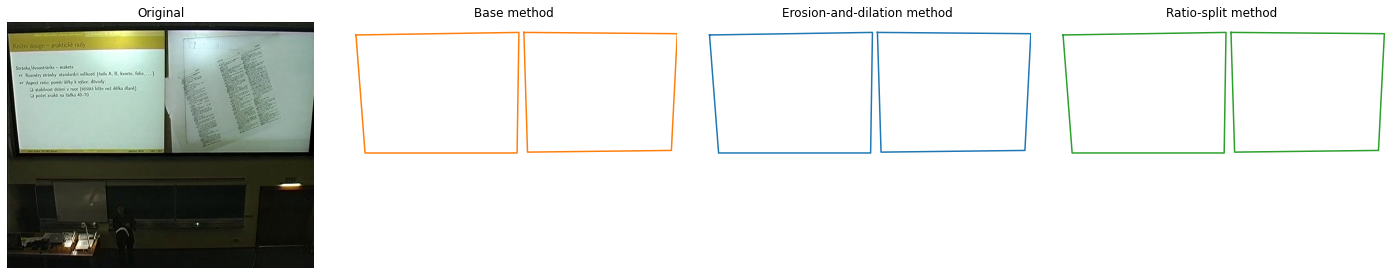

In [64]:
i = 0
for sem, frame in interesting_things[1:2]:
    base_screens = detector.post_processing(sem, frame, **base_methods)
    print(detector.post_processing_params)
    erode_screens = detector.post_processing(sem, frame, **erode_methods)
    print(detector.post_processing_params)
    ratio_screens = detector.post_processing(sem, frame, **ratio_methods)
    print(detector.post_processing_params)
    methods_visualization(frame, base_screens, erode_screens, ratio_screens, save = i + 1)   
    i += 1

## Base

In [61]:
base_methods = {'base': True,
    'base_factors': [0.1, 0.01],
    'base_lower_bound': 7,
    'base_upper_bound': 50,
    'erode_dilate': False,
    'ratio_split': False}

In [30]:
factors = [0.2, 0.1, 0.01]

In [31]:
interesting_things = list(zip(interesting_sems, interesting_frames))
sem, frame = interesting_things[0]

IndexError: list index out of range

In [32]:
plt.imshow(sem)
plt.savefig(fname=f'/content/drive/My Drive/Colab Notebooks/sem_factor.png', bbox_inches='tight', pad_inches=0)

NameError: name 'sem' is not defined

In [0]:
copy = frame.image.copy()

contours, _ = cv2.findContours(sem, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
previous_quadrangle = None
for i, factor in enumerate(factors):
    quadrangles = contour_approx(contours, 7, 99, [factor], debug=True)

    for quadrangle in quadrangles:
        copy = cv2.fillConvexPoly(copy, quadrangle, color=1)
    
    plt.imshow(copy)
    plt.savefig(fname=f'/content/drive/My Drive/Colab Notebooks/{factor}_factor.png', bbox_inches='tight', pad_inches=0)
    plt.show()

## Erode dilate

In [0]:
sem, frame = interesting_things[1]
plt.imshow(sem)
plt.savefig(fname=f'/content/drive/My Drive/Colab Notebooks/sem_erode.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [0]:
erosed = cv2.erode(sem, None, iterations=40)
plt.imshow(erosed)
plt.savefig(fname=f'/content/drive/My Drive/Colab Notebooks/erode_erode.png', bbox_inches='tight', pad_inches=0)

contours, _ = cv2.findContours(erosed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
quadrangles = contour_approx(contours, 5, 70, [0.1, 0.01])

erosed_dilated_quadrangles = []
for i, quadrangle in enumerate(quadrangles):
    zeros = np.zeros(sem.shape, dtype='uint8')
    erosed_quadrangle = draw_polygon(quadrangle, zeros)
    dilated_quadrangle = cv2.dilate(erosed_quadrangle, None, iterations=40)
    plt.imshow(dilated_quadrangle)
    plt.savefig(fname=f'/content/drive/My Drive/Colab Notebooks/{i}_dilated_erode.png', bbox_inches='tight', pad_inches=0)
    contours, _ = cv2.findContours(dilated_quadrangle, cv2.RETR_TREE,
                                    cv2.CHAIN_APPROX_SIMPLE)

In [0]:
iterations_ = [10, 40, 100]
for i, it in enumerate(iterations_):
    erosed = cv2.erode(sem, None, iterations=it)
    plt.imshow(erosed)
    plt.savefig(fname=f'/content/drive/My Drive/Colab Notebooks/{i}_eroded.png', bbox_inches='tight', pad_inches=0)
    plt.show()

    dilated = cv2.dilate(erosed, None, iterations=it)
    plt.imshow(dilated)
    plt.savefig(fname=f'/content/drive/My Drive/Colab Notebooks/{i}_dilated.png', bbox_inches='tight', pad_inches=0)
    plt.show()

## Kernel size vs iterations

In [0]:
sem, frame = interesting_things[1]

In [0]:
iterations = 40

In [0]:
kernel = np.ones((80, 80), np.uint8)

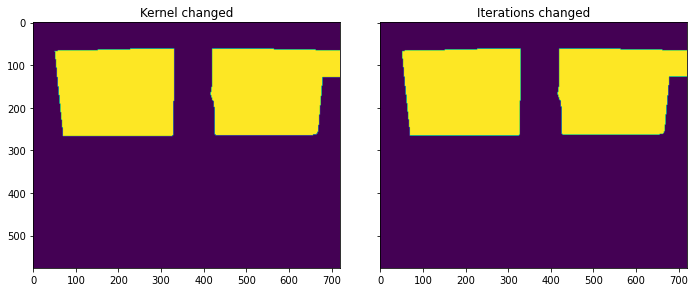

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex='row', sharey='row')
fig.tight_layout()
axes[0].set_title("Kernel changed")
axes[0].imshow(cv2.erode(sem, kernel=kernel))
axes[1].set_title("Iterations changed")
axes[1].imshow(cv2.erode(sem, None, iterations=iterations))

In [0]:
%%timeit -n 1000 -r 2
cv2.erode(sem, kernel=kernel)

1000 loops, best of 2: 762 µs per loop


In [0]:
%%timeit -n 1000 -r 2
cv2.erode(sem, None, iterations=iterations)

1000 loops, best of 2: 1.52 ms per loop


In [0]:
e_kernel = cv2.erode(sem, kernel=kernel)
e_iter = cv2.erode(sem, None, iterations=iterations)

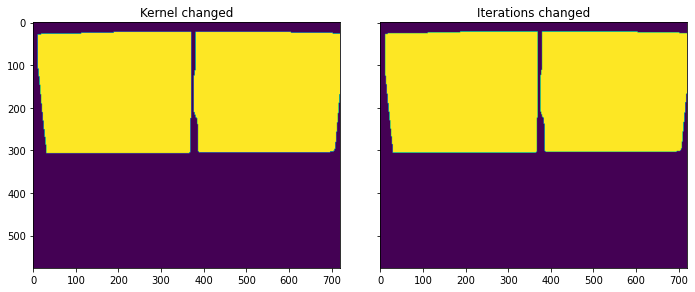

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex='row', sharey='row')
fig.tight_layout()
axes[0].set_title("Kernel changed")
axes[0].imshow(cv2.dilate(e_kernel, kernel=kernel))
axes[1].set_title("Iterations changed")
axes[1].imshow(cv2.dilate(e_iter, None, iterations=iterations))

In [0]:
%%timeit -n 1000 -r 2
cv2.dilate(sem, kernel=kernel)

1000 loops, best of 2: 1.5 ms per loop


In [0]:
%%timeit -n 1000 -r 2
cv2.dilate(sem, None, iterations=iterations)

1000 loops, best of 2: 1.53 ms per loop


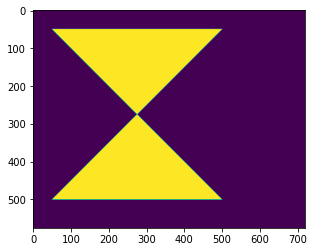

In [0]:
blank_image = np.zeros((576, 720))
shape = np.array([[[50, 50], [500, 50], [50, 500], [500, 500]]])
image = cv2.fillConvexPoly(blank_image, shape, color=1)
plt.imshow(image)

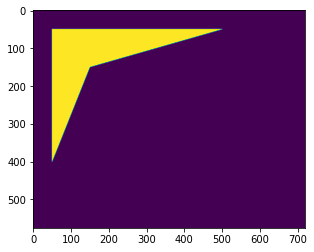

In [0]:
blank_image = np.zeros((576, 720))
shape = np.array([[[50, 50], [500, 50], [150, 150], [50, 400]]])
image = cv2.fillConvexPoly(blank_image, shape, color=1)
plt.imshow(image)

In [0]:
contours, _ = cv2.findContours(image.astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [0]:
epsilon = 0.01 * cv2.arcLength(contours[0], True)
polygon = cv2.approxPolyDP(contours[0], epsilon, True)

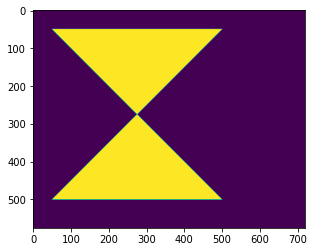

In [0]:
plt.imshow(draw_polygon(polygon, np.zeros((576, 720))))

In [0]:
def draw_polygon(polygon, image):
    copy = image.copy()
    return cv2.fillConvexPoly(copy, polygon, 100)

In [0]:
polygon.shape[0] == 4 and not 100*cv2.contourArea(polygon) /  (576*720) < 5

True

array([[[ 50.,  50.],
        [700.,  50.],
        [ 50., 300.],
        [700., 300.]]])

In [0]:
type(get_transforms(do_flip=True, flip_vert=False, max_lighting=0.8,
                              p_affine=0, p_lighting=0.5))

tuple

### Contour approximation binary search algorithm